# Advanced RAG Eval

The cookbook walks through the process of running eval(s) on advanced RAG. 

This can be very useful to determine the best RAG approach for your application.

In [1]:
! pip install -U langchain openai chromadb langchain-experimental # (newest versions required for multi-modal)

  Obtaining dependency information for langchain from https://files.pythonhosted.org/packages/65/f4/dea10c11f0c2ebca298ba57f546940f8944e49c624239183c924ae0e1f81/langchain-0.0.339-py3-none-any.whl.metadata
  Obtaining dependency information for openai from https://files.pythonhosted.org/packages/8a/6c/f345662c586464cbd6185239ddea4d281b623db302115ff7a2bb27db1eea/openai-1.3.4-py3-none-any.whl.metadata
  Obtaining dependency information for chromadb from https://files.pythonhosted.org/packages/0d/e9/117169df4027a5475ec6406c49f4c5f0ed2b7a7e46d10f02ab5fc049e9ca/chromadb-0.4.18-py3-none-any.whl.metadata
  Obtaining dependency information for langchain-experimental from https://files.pythonhosted.org/packages/bd/34/147eb8d99408c200b2d0d6fc26841833542123622cb45c27af8f33a7d925/langchain_experimental-0.0.42-py3-none-any.whl.metadata
  Obtaining dependency information for chroma-hnswlib==0.7.3 from https://files.pythonhosted.org/packages/11/7a/673ccb9bb2faf9cf655d9040e970c02a96645966e06837fde7d10e

In [2]:
# lock to 0.10.19 due to a persistent bug in more recent versions
! pip install "unstructured[all-docs]==0.10.19" pillow pydantic lxml pillow matplotlib tiktoken open_clip_torch torch

  Obtaining dependency information for unstructured[all-docs]==0.10.19 from https://files.pythonhosted.org/packages/40/07/5acccc63e96a2ddf6040b9b3c2a8b258abc4fad5671364917b01301cd2be/unstructured-0.10.19-py3-none-any.whl.metadata
  Obtaining dependency information for lxml from https://files.pythonhosted.org/packages/d6/56/9d5cb3438143a5aebad59088ca392950d74a531e1b96d0959144370b3b59/lxml-4.9.3-cp311-cp311-macosx_11_0_universal2.whl.metadata
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/ce/25/a557ee10ac9dce1300850024707ce1850a6958f1673a9194be878b99d631/matplotlib-3.8.2-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for tiktoken from https://files.pythonhosted.org/packages/fb/2a/3d02ef030f387c373acbeca6d5a2307405a1da735285ec12a9ed0b6302ea/tiktoken-0.5.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for open_clip_torch from https://files.pythonhosted.org/packages/7c/7f/952fdffa1

## Data Loading

Let's look at an [example whitepaper](https://sgp.fas.org/crs/misc/IF10244.pdf) that provides a mixture of tables, text, and images about Wildfires in the US.

### Option 1: Load text

In [1]:
# Path
path = "/Users/rlm/Desktop/cpi/"

# Load
from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader(path + "cpi.pdf")
pdf_pages = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=0)
all_splits_pypdf = text_splitter.split_documents(pdf_pages)
all_splits_pypdf_texts = [d.page_content for d in all_splits_pypdf]

### Option 2: Load text, tables, images 



In [2]:
from unstructured.partition.pdf import partition_pdf

# Extract images, tables, and chunk text
raw_pdf_elements = partition_pdf(
    filename=path + "cpi.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=path,
)

# Categorize by type
tables = []
texts = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element))

## Store

### Option 1: Embed, store text chunks

In [3]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import Chroma

baseline = Chroma.from_texts(
    texts=all_splits_pypdf_texts,
    collection_name="baseline",
    embedding=OpenAIEmbeddings(),
)
retriever_baseline = baseline.as_retriever()

### Option 2: Multi-vector retriever

#### Text Summary

In [4]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

# Prompt
prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
These summaries will be embedded and used to retrieve the raw text or table elements. \
Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
prompt = ChatPromptTemplate.from_template(prompt_text)

# Text summary chain
model = ChatOpenAI(temperature=0, model="gpt-4")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# Apply to text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

# Apply to tables
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

#### Image Summary

In [9]:
# Image summary chain
import base64
import io
import os
from io import BytesIO

from langchain.schema.messages import HumanMessage
from PIL import Image


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64, prompt):
    """Image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


# Store base64 encoded images
img_base64_list = []

# Store image summaries
image_summaries = []

# Prompt
prompt = """You are an assistant tasked with summarizing images for retrieval. \
These summaries will be embedded and used to retrieve the raw image. \
Give a concise summary of the image that is well optimized for retrieval."""

# Apply to images
for img_file in sorted(os.listdir(path)):
    if img_file.endswith(".jpg"):
        img_path = os.path.join(path, img_file)
        base64_image = encode_image(img_path)
        img_base64_list.append(base64_image)
        image_summaries.append(image_summarize(base64_image, prompt))

### Option 2a: Multi-vector retriever w/ raw images

* Return images to LLM for answer synthesis

In [11]:
import uuid
from base64 import b64decode

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
multi_vector_img = Chroma(
    collection_name="multi_vector_img", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    multi_vector_img,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [32]:
# Testing on retrieval
query = "What percentage of CPI is dedicated to Housing, and how does it compare to the combined percentage of Medical Care, Apparel, and Other Goods and Services?"
suffix_for_images = " Include any pie charts, graphs, or tables."
docs = retriever_multi_vector_img.get_relevant_documents(query + suffix_for_images)


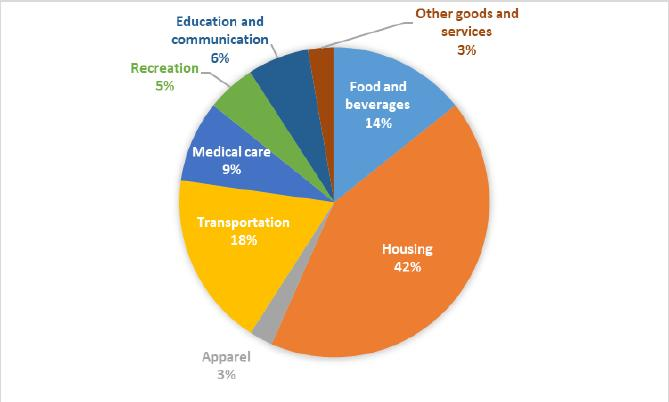

In [19]:
from IPython.display import HTML, display


def plt_img_base64(img_base64):
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'

    # Display the image by rendering the HTML
    display(HTML(image_html))


plt_img_base64(docs[1])

### Option 2b: Multi-vector retriever w/ image summaries

* Return text summary of images to LLM for answer synthesis

In [20]:
# The vectorstore to use to index the summaries
multi_vector_text = Chroma(
    collection_name="multi_vector_text", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img_summary = create_multi_vector_retriever(
    multi_vector_text,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    image_summaries,
)

### Option 3: Multi-modal embeddings

In [22]:
from langchain_experimental.open_clip import OpenCLIPEmbeddings

# Create chroma w/ multi-modal embeddings
multimodal_embd = Chroma(
    collection_name="multimodal_embd", embedding_function=OpenCLIPEmbeddings()
)

# Get image URIs
image_uris = sorted(
    [
        os.path.join(path, image_name)
        for image_name in os.listdir(path)
        if image_name.endswith(".jpg")
    ]
)

# Add images and documents
if image_uris:
    multimodal_embd.add_images(uris=image_uris)
if texts:
    multimodal_embd.add_texts(texts=texts)
if tables:
    multimodal_embd.add_texts(texts=tables)

# Make retriever
retriever_multimodal_embd = multimodal_embd.as_retriever()

## RAG

### Text Pipeline

In [23]:
from operator import itemgetter

from langchain.schema.runnable import RunnablePassthrough

# Prompt
template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
rag_prompt_text = ChatPromptTemplate.from_template(template)


# Build
def text_rag_chain(retriever):
    """RAG chain"""

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4")

    # RAG pipeline
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | rag_prompt_text
        | model
        | StrOutputParser()
    )

    return chain

### Multi-modal Pipeline

In [24]:
import re

from langchain.schema import Document
from langchain.schema.runnable import RunnableLambda


def looks_like_base64(sb):
    """Check if the string looks like base64."""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """Check if the base64 data is an image by looking at the start of the data."""
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def split_image_text_types(docs):
    """Split base64-encoded images and texts."""
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    # Joining the context texts into a single string
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        image_message = {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{data_dict['context']['images'][0]}"
            },
        }
        messages.append(image_message)

    # Adding the text message for analysis
    text_message = {
        "type": "text",
        "text": (
            "Answer the question based only on the provided context, which can include text, tables, and image(s). "
            "If an image is provided, analyze it carefully to help answer the question.\n"
            f"User-provided question / keywords: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """Multi-modal RAG chain"""

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

### Build RAG Pipelines

In [25]:
# RAG chains
chain_baseline = text_rag_chain(retriever_baseline)
chain_mv_text = text_rag_chain(retriever_multi_vector_img_summary)

# Multi-modal RAG chains
chain_multimodal_mv_img = multi_modal_rag_chain(retriever_multi_vector_img)
chain_multimodal_embd = multi_modal_rag_chain(retriever_multimodal_embd)

## Eval set

In [34]:
# Read
import pandas as pd

eval_set = pd.read_csv(path + "cpi_eval.csv")
eval_set.head(3)

,Question,Answer,Source
0,What percentage of CPI is dedicated to Housing?,Housing occupies 42% of CPI.,Figure 1
1,Medical Care and Transportation account for wh...,Transportation accounts for 18% of CPI. Medica...,Figure 1
2,Based on the CPI Owners' Equivalent Rent and t...,The FHFA Purchase Only Price Index appears to ...,Figure 2


In [35]:
from langsmith import Client

# Dataset
client = Client()
dataset_name = f"CPI Eval {str(uuid.uuid4())}"
dataset = client.create_dataset(dataset_name=dataset_name)

# Populate dataset
for _, row in eval_set.iterrows():
    # Get Q, A
    q = row["Question"]
    a = row["Answer"]
    # Use the values in your function
    client.create_example(
        inputs={"question": q}, outputs={"answer": a}, dataset_id=dataset.id
    )

In [36]:
from langchain.smith import RunEvalConfig

eval_config = RunEvalConfig(
    evaluators=["qa"],
)


def run_eval(chain, run_name, dataset_name):
    _ = client.run_on_dataset(
        dataset_name=dataset_name,
        llm_or_chain_factory=lambda: (lambda x: x["question"] + suffix_for_images)
        | chain,
        evaluation=eval_config,
        project_name=run_name,
    )


for chain, run in zip(
    [chain_baseline, chain_mv_text, chain_multimodal_mv_img, chain_multimodal_embd],
    ["baseline", "mv_text", "mv_img", "mm_embd"],
):
    run_eval(chain, dataset_name + "-" + run, dataset_name)

View the evaluation results for project 'CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126-baseline' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/projects/p/533846be-d907-4d9c-82db-ce2f1a18fdbf?eval=true

View all tests for Dataset CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126 at:
https://smith.langchain.com/datasets/d1762232-5e01-40e7-9978-63002a4c95a3
[------------------------------------------------->] 4/4View the evaluation results for project 'CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126-mv_text' at:
https://smith.langchain.com/o/1fa8b1f4-fcb9-4072-9aa9-983e35ad61b8/projects/p/f5caeede-6f8e-46f7-b4f2-9f23daa31eda?eval=true

View all tests for Dataset CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126 at:
https://smith.langchain.com/datasets/d1762232-5e01-40e7-9978-63002a4c95a3
[------------------------------------------------->] 4/4View the evaluation results for project 'CPI Eval 9648e7fe-5ae2-469f-8701-33c63212d126-mv_img' at:
https://smith.langchain.com/o/1fa8